# Time series analysis forecasting for tire product

produced by Colin Shu
--9/8/2019

&nbsp;&nbsp;GoodTires.com is an online retailer, selling replacement tires for autos and light trucks. The company is interested in constructing a short-term sales forecasting method for this product. The forecast will be used to make one-week-ahead forecasts so that they can make ordering decisions from the tire manufacturer for the following week. <br>
&nbsp;&nbsp;For a basic time series forecasting, I tried two different models – a 3-week weighted moving average and single exponential smoothing – to forecast this product’s sales. The parameters are estimated for each type of model (to minimize MSE), using the data from the first three quarters of the year (39 observations), the rest of the data are used for model validation (13 observations). The CFE, MAD and MAPE measures are computed on the remaining 13 observations (the last quarter of the year) and each model is evaluated.

## Import the data, clean the data and exploratory data analysis

In [309]:
# import basic libraries
import pandas as pd
import numpy as np
from random import random

# import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

Import the data set and clean the data

In [30]:
# import the data
data = pd.read_excel("CEE 5930 Assignment 1 Data -- Fall 2019.xlsx", sheetname='GoodTires Data')
data.head()

,Weekly Sales,Unnamed: 1
0,Week,Units Sold
1,1,287
2,2,290
3,3,268
4,4,270


In [31]:
data.columns = list(data.iloc[0].values)
df = data.drop(data.index[0])

In [32]:
# make sure the rows are 52 in total
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1 to 52
Data columns (total 2 columns):
Week          52 non-null object
Units Sold    52 non-null object
dtypes: object(2)
memory usage: 1.2+ KB


In [33]:
df.index = df['Week']

In [35]:
df = df['Units Sold']

In [37]:
df.head()

Week
1    287
2    290
3    268
4    270
5    262
Name: Units Sold, dtype: object

A quick visualization of the time series data

Text(0.5, 1.0, 'the actual unit sold each week')

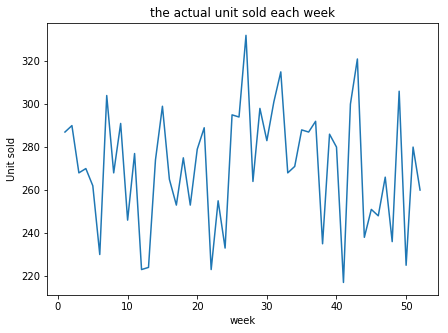

In [311]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.lineplot(x=list(df.index), y=list(df.values))
plt.xlabel('week')
plt.ylabel('Unit sold')
plt.title('the actual unit sold each week')

&nbsp;&nbsp;To forecast the next week product sales, the first 3/4 data is used, for two kinds of models, to find the appropriate the parameters which minimize the MSE value. Then the last 1/4 data is used to evaluate the two models, comparing the different measures (CFE, MAD and MAPE).

## Using the data from the first three quarters of the year to train the two models and find best parameters for each model

###  A 3-week weighted moving average model

Before calculate the moving average forecasting, the parameters of the three parameters need to be generated

In [272]:
# generate three weighted parameters with the fixed sum of 1
def generate_groups_of_params(groups=10):
    groups_of_params = []
    for i in range(groups):
        w1 = random()
        w2 = (1-w1)*random()
        w3 = 1-w1-w2
        groups_of_params.append((w1,w2,w3))
    return groups_of_params

In [273]:
params = list(set(generate_groups_of_params(groups=1000000)))

In [274]:
params[0]

(0.9957585783691869, 0.0028212801347681205, 0.001420141496044971)

In [275]:
params.append((0.1, 0.2, 0.7))
# check the final parameter set size
len(params)

1000001

In [276]:
# calculate each moving average forecasting using each parameter group (among the 1001)
def moving_average_forecasting(data,
                               useful_history=3, 
                               parameters=params,
                               observation_for_model_training=39
                               ):
    forecast_results = []
    for params in parameters:
        forecast_result = []
        for idx,value in enumerate(data):
            if idx <= useful_history-1:
                forecast_result.append(value)
            else:
                wt_3_week_ago = data[idx-useful_history]
                wt_2_week_ago = data[idx-useful_history+1]
                wt_1_week_ago = data[idx-useful_history+2]
                forecast = wt_3_week_ago*params[0] + wt_2_week_ago*params[1] + wt_1_week_ago*params[2]
                forecast_result.append(forecast)
        forecast_result = forecast_result[0:observation_for_model_training-1]
        forecast_results.append(forecast_result)
    return forecast_results

In [277]:
forecast_results_MA = moving_average_forecasting(list(df.values), 
                                                 useful_history=3, 
                                                 parameters=params,
                                                 observation_for_model_training=39)

In [278]:
len(forecast_results_MA)

1000001

In [279]:
forecast_results_MA[0]

[287,
 290,
 268,
 286.98148115197944,
 289.9095290071142,
 267.99712171129323,
 269.92062409908004,
 261.96936497852136,
 230.26274010682258,
 303.87997207569975,
 268.0336463301866,
 290.8531604129908,
 246.05479642976877,
 276.7723833734321,
 223.07524849643306,
 224.24757461894177,
 274.0577507299048,
 298.83874996659983,
 264.9803460533432,
 253.0620681629649,
 274.9436124030193,
 253.12447837736158,
 278.9486848775692,
 288.7655107002398,
 223.104482379273,
 254.9947374968769,
 233.26154799961435,
 295.0497239552189,
 294.06460440023983,
 331.75986813997025,
 264.12290621300696,
 297.9619412224666,
 283.0962275702993,
 300.9926332525173,
 314.80491360784,
 268.0368666703252,
 271.0706840262278,
 288.0028592858494]

After using all the 1000001 parameters, I calculated the prediction for the 36 (39-3) sales, as shown above. Then, I can calculate the MSE (mean squared error), which is considered as the objective function to be minimize to find out the best parameters for this 3-week moving average model.

In [280]:
def best_params_set_which_minimizes_MSE_MA(actual_value,
                                           params,
                                           forecast_results):
    # initiate the MSE and best parameters
    MSE = sum((np.array(forecast_results[0][3:]) - np.array(list(df.values)[3:38]))**2)/len(actual_value)
    best_params = (0.1, 0.2, 0.7)
    for param, forecast_result in zip(params,forecast_results):
        new_MSE = sum((np.array(forecast_result[3:]) - np.array(list(df.values)[3:38]))**2)/len(actual_value)
        if new_MSE < MSE:
            MSE = new_MSE
            best_params = param
    return (best_params, MSE)

In [281]:
best_params_MA = best_params_set_which_minimizes_MSE_MA(list(df.values), params, forecast_results_MA)

In [282]:
best_params_MA

((0.09836119121117448, 0.47308005978253054, 0.428558749006295),
 624.3263750819804)

### A single exponential smoothing model

In [283]:
# generate the parameters for the single exponential smoothing model
alphas = np.linspace(0,1,1000001)

In [284]:
def single_exponential_smoothing_model_forecasting(data,
                                                   parameters=alphas,
                                                   observation_for_model_training=39
                                                   ):
    forecast_results = []
    for alpha in alphas:
        forecast_result = []
        for idx,value in enumerate(data):
            if idx == 0:
                forecast_result.append(value)
            else:
                forecast = alpha*(data[idx-1]-forecast_result[idx-1]) + forecast_result[idx-1]
                forecast_result.append(forecast)
        forecast_result = forecast_result[0:observation_for_model_training-1]
        forecast_results.append(forecast_result)
    return forecast_results

In [285]:
forecast_results_ES = single_exponential_smoothing_model_forecasting(list(df.values),
                                                                     parameters=alphas,
                                                                     observation_for_model_training=39)

In [286]:
len(forecast_results_ES)

1000001

In [290]:
def best_alpha_which_minimizes_MSE_ES(actual_value,
                                      alphas,
                                      forecast_results):
    # initiate the MSE and best alpha
    MSE = sum((np.array(forecast_results[0]) - np.array(list(df.values)[0:38]))**2)/len(actual_value)
    best_alpha = 0
    for alpha, forecast_result in zip(alphas, forecast_results):
        new_MSE = sum((np.array(forecast_result) - np.array(list(df.values)[0:38]))**2)/len(actual_value)
        if new_MSE < MSE:
            MSE = new_MSE
            best_alpha = alpha
    return (best_alpha, MSE)

In [291]:
best_alpha_ES = best_alpha_which_minimizes_MSE_ES(list(df.values), alphas, forecast_results_ES)

In [292]:
best_alpha_ES

(0.153721, 537.0874844280161)

## After finding out the best parameters for each model, use the rest of the data for model validation (CFE, MAD and MAPE measures are computed to evaluate the models)

In [293]:
# forecast the product sales using 3-week weighted moving average model with the best parameters found
forecast_result_MA = []
for idx,value in enumerate(list(df.values)):
    if idx <= 2:
        forecast_result_MA.append(value)
    else:
        wt_3_week_ago = list(df.values)[idx-3]
        wt_2_week_ago = list(df.values)[idx-2]
        wt_1_week_ago = list(df.values)[idx-1]
        forecast = (wt_3_week_ago*best_params_MA[0][0] + 
                    wt_2_week_ago*best_params_MA[0][1] + 
                    wt_1_week_ago*best_params_MA[0][2])
        forecast_result_MA.append(forecast)

In [294]:
forecast_result_MA

[287,
 290,
 268,
 280.276623948228,
 271.02106370465845,
 266.3748076255273,
 249.07300956148794,
 264.86090554522343,
 281.29315688614645,
 281.39785411074706,
 269.4525488968597,
 263.71157482369796,
 250.80863062611365,
 228.74006307440973,
 245.3295762591036,
 279.79590916459864,
 281.9699727535066,
 263.2015755131044,
 263.60862677267255,
 263.4077613152157,
 266.3064736808095,
 280.7281965185724,
 259.7315106534728,
 243.20571858813895,
 242.4241494031039,
 261.7345886450361,
 288.4730473959009,
 310.38359365345036,
 299.1202798015473,
 285.2595584685739,
 288.22733826372564,
 292.18947535028093,
 305.22932104428696,
 293.4806821197477,
 273.9086522339441,
 277.9904151594735,
 285.89930100040374,
 289.24115493624265,
 267.08034535058533,
 262.46308409835797,
 278.4122267541923,
 253.59096595987046,
 258.7671312138265,
 300.8357548586047,
 283.3640388170429,
 251.7352426076093,
 248.43562826723584,
 256.00914105574685,
 251.37273608801002,
 268.94994816677587,
 264.4014579457079,

In [295]:
# forecast the product sales using single exponential smoothing model with the best alpha found
forecast_result_ES = []
for idx,value in enumerate(list(df.values)):
    if idx == 0:
        forecast_result_ES.append(value)
    else:
        forecast = best_alpha_ES[0]*(list(df.values)[idx-1]-forecast_result_ES[idx-1]) + forecast_result_ES[idx-1]
        forecast_result_ES.append(forecast)

In [296]:
forecast_result_ES

[287,
 287.0,
 287.461163,
 284.469573562477,
 282.2452962448795,
 279.13316906082036,
 271.580369179622,
 276.5639472489613,
 275.24748871390375,
 277.66898050131374,
 272.8007931496713,
 273.44629942591064,
 265.69164383186023,
 259.28276265038284,
 261.54511109300336,
 267.3027140706758,
 266.9487385610174,
 264.80452452067925,
 266.3717832068359,
 264.31625932049786,
 266.5734586214916,
 270.0208889887373,
 262.7927909124996,
 261.5948753006392,
 257.19924247454964,
 263.01001272211937,
 267.77382455646244,
 277.6467364718185,
 275.5489464946341,
 279.00014489053245,
 279.6150066178149,
 282.9023291855178,
 287.8364152407908,
 284.7871416535612,
 282.66776845143414,
 283.4874444173112,
 284.02739797403774,
 285.2529543300707,
 277.5280199374979,
 278.8303411846858,
 279.0101423074347,
 269.47788122179355,
 274.1697718424982,
 281.36856134509753,
 274.7019027265678,
 271.05842253753707,
 267.5138587666443,
 267.281146883177,
 262.47257770314815,
 269.1636565860425,
 262.374775131979

In [303]:
# calculate the CFE, MAD and MAPE measures
def CFE(data, predicted_results):
    return sum(np.array(data)-np.array(predicted_results))

def MAD(data, predicted_results):
    return sum(abs(np.array(data)-np.array(predicted_results)))/len(data)

def MAPE(data, predicted_results):
    return (100/len(data))*sum(abs(np.array(data)-np.array(predicted_results))/np.array(data))

CFE_MA = CFE(list(df.values)[-13:], forecast_result_MA[-13:])
MAD_MA = MAD(list(df.values)[-13:], forecast_result_MA[-13:])
MAPE_MA = MAPE(list(df.values)[-13:], forecast_result_MA[-13:])

CFE_ES = CFE(list(df.values)[-13:], forecast_result_ES[-13:])
MAD_ES = MAD(list(df.values)[-13:], forecast_result_ES[-13:])
MAPE_ES = MAPE(list(df.values)[-13:], forecast_result_ES[-13:])

In [317]:
measure_df = pd.DataFrame(np.array([[[round(param,5) for param in best_params_MA[0]],
                                     best_params_MA[1], CFE_MA, MAD_MA, MAPE_MA], 
                                    [round(best_alpha_ES[0],5), 
                                     best_alpha_ES[1], CFE_ES, MAD_ES, MAPE_ES]]),
                          index=['3-week MA model', 'single ES model'],
                          columns=['parameters', 'MSE', 'CFE', 'MAD', 'MAPE'])

In [318]:
measure_df

,parameters,MSE,CFE,MAD,MAPE
3-week MA model,"[0.09836, 0.47308, 0.42856]",624.326,-6.87534,33.9798,13.0455
single ES model,0.15372,537.087,-94.5072,28.7582,11.2805


## Overall results

Text(0.5, 1.0, 'the actual and predicted unit sold each week')

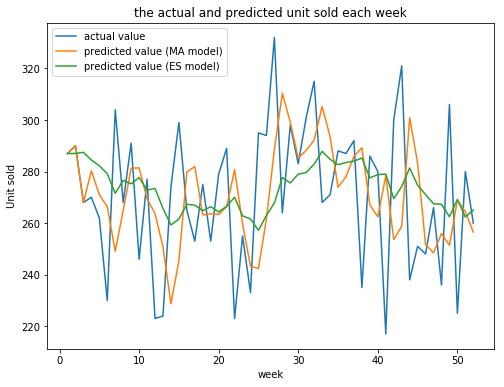

In [315]:
# plot the actual value and predicted sales value
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(x=list(df.index), y=list(df.values), label='actual value')
ax = sns.lineplot(x=list(df.index), y=forecast_result_MA, label='predicted value (MA model)')
ax = sns.lineplot(x=list(df.index), y=forecast_result_ES, label='predicted value (ES model)')
plt.xlabel('week')
plt.ylabel('Unit sold')
plt.legend()
plt.title('the actual and predicted unit sold each week')

In [319]:
measure_df

,parameters,MSE,CFE,MAD,MAPE
3-week MA model,"[0.09836, 0.47308, 0.42856]",624.326,-6.87534,33.9798,13.0455
single ES model,0.15372,537.087,-94.5072,28.7582,11.2805


&nbsp;&nbsp;Calculated different measures of each model, we can compare the two models and evaluate them. From the data frame above, we learn that in term of the CFE measure, the 3-week moving average model performs better, while in term of the MSE, MAD and MAPE measures the single exponential smoothing model performs better.
<br>
&nbsp;&nbsp;Overall, according to the measures, the single exponential smoothing model performs better.

## Discussion

&nbsp;&nbsp;Combined with the plots, it is clear that the moving average model can demonstrate better the dynamics, while the exponential smoothing model can demonstrate the internal trend.